# Method 7 - Best Minus Rest Top 5

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns from Intra-Cap Portfolio Weight per Shumway, Szefler, Yuan 2009

%store -r cap_exp_ret

valid_data = valid_data.merge(cap_exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)
                                                                                         
# Split Long and Short and Filter to Highest Tilts

long_ideas = valid_data[valid_data['pos_rank'] <= 5].copy()                                                                                         
short_ideas = valid_data[valid_data['pos_rank'] > 5].copy()

# Weight the best ideas

long_ideas['target'] = long_ideas['target'] / long_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / long_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

short_ideas['target'] = - short_ideas['target'] / short_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / short_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

best_ideas = pd.concat([long_ideas, short_ideas])

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

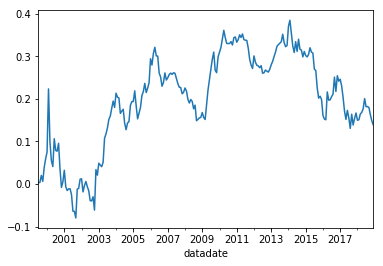

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.058838
2000-12-31   -0.051015
2001-12-31    0.006466
2002-12-31    0.009215
2003-12-31    0.155955
2004-12-31    0.011654
2005-12-31    0.037334
2006-12-31    0.004873
2007-12-31   -0.023108
2008-12-31   -0.048621
2009-12-31    0.122859
2010-12-31    0.036229
2011-12-31   -0.055019
2012-12-31   -0.001275
2013-12-31    0.043643
2014-12-31   -0.010538
2015-12-31   -0.085811
2016-12-31    0.035622
2017-12-31   -0.060179
2018-12-31   -0.024025
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     90.45
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.28e-46
Time:                        21:54:48   Log-Likelihood:                 669.70
No. Observations:                 234   AIC:                            -1329.
Df Residuals:                     229   BIC:                            -1312.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.282      0.201      -0.001       0.003
mktrf         -0.0790      0.026     -3.030      0.003      -0.130      -0.028
me             0.3506      0.030     11.560      0.000       0.291       0.410
ia            -0.0826      0.046     -1.791      0.075      -0.173       0.008
roe           -0.3615      0.039     -9.160      0.000      -0.439      -0.284
==============================================================================
Omnibus:                       27.111   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.056
Skew:                           0.476   Prob(JB):                     1.37e-16
Kurtosis:                       5.566   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     40.93
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           7.32e-26
Time:                        21:54:48   Log-Likelihood:                 669.70
No. Observations:                 234   AIC:                            -1329.
Df Residuals:                     229   BIC:                            -1312.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.324      0.185      -0.001       0.003
mktrf         -0.0790      0.034     -2.302      0.021      -0.146      -0.012
me             0.3506      0.054      6.513      0.000       0.245       0.456
ia            -0.0826      0.068     -1.217      0.224      -0.216       0.050
roe           -0.3615      0.067     -5.391      0.000      -0.493      -0.230
==============================================================================
Omnibus:                       27.111   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.056
Skew:                           0.476   Prob(JB):                     1.37e-16
Kurtosis:                       5.566   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.612
Model:                            OLS   Adj. R-squared:                  0.606
Method:                 Least Squares   F-statistic:                     45.89
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.76e-28
Time:                        21:54:48   Log-Likelihood:                 669.70
No. Observations:                 234   AIC:                            -1329.
Df Residuals:                     229   BIC:                            -1312.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.344      0.179      -0.001       0.003
mktrf         -0.0790      0.032     -2.436      0.015      -0.143      -0.015
me             0.3506      0.053      6.571      0.000       0.246       0.455
ia            -0.0826      0.074     -1.109      0.267      -0.228       0.063
roe           -0.3615      0.070     -5.185      0.000      -0.498      -0.225
==============================================================================
Omnibus:                       27.111   Durbin-Watson:                   2.108
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               73.056
Skew:                           0.476   Prob(JB):                     1.37e-16
Kurtosis:                       5.566   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     97.80
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.96e-55
Time:                        21:54:48   Log-Likelihood:                 692.86
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     228   BIC:                            -1353.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.278      0.203      -0.001       0.003
mktrf         -0.0410      0.024     -1.729      0.085      -0.088       0.006
smb            0.3448      0.031     11.019      0.000       0.283       0.406
hml           -0.0803      0.037     -2.176      0.031      -0.153      -0.008
rmw           -0.3660      0.042     -8.773      0.000      -0.448      -0.284
cma            0.1245      0.053      2.348      0.020       0.020       0.229
==============================================================================
Omnibus:                       28.206   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.397
Skew:                           0.556   Prob(JB):                     6.30e-15
Kurtosis:                       5.339   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     162.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.38e-73
Time:                        21:54:48   Log-Likelihood:                 692.86
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     228   BIC:                            -1353.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.374      0.169      -0.000       0.003
mktrf         -0.0410      0.025     -1.644      0.100      -0.090       0.008
smb            0.3448      0.030     11.398      0.000       0.286       0.404
hml           -0.0803      0.056     -1.441      0.150      -0.190       0.029
rmw           -0.3660      0.052     -7.074      0.000      -0.467      -0.265
cma            0.1245      0.067      1.870      0.061      -0.006       0.255
==============================================================================
Omnibus:                       28.206   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.397
Skew:                           0.556   Prob(JB):                     6.30e-15
Kurtosis:                       5.339   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     195.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.29e-80
Time:                        21:54:48   Log-Likelihood:                 692.86
No. Observations:                 234   AIC:                            -1374.
Df Residuals:                     228   BIC:                            -1353.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0011      0.001      1.434      0.152      -0.000       0.003
mktrf         -0.0410      0.027     -1.533      0.125      -0.093       0.011
smb            0.3448      0.031     11.168      0.000       0.284       0.405
hml           -0.0803      0.051     -1.577      0.115      -0.180       0.019
rmw           -0.3660      0.052     -7.101      0.000      -0.467      -0.265
cma            0.1245      0.067      1.860      0.063      -0.007       0.256
==============================================================================
Omnibus:                       28.206   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.397
Skew:                           0.556   Prob(JB):                     6.30e-15
Kurtosis:                       5.339   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     84.58
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.35e-44
Time:                        21:54:48   Log-Likelihood:                 664.95
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     229   BIC:                            -1303.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.191      0.849      -0.002       0.002
mktrf          0.0108      0.024      0.440      0.660      -0.037       0.059
smb            0.4908      0.031     16.048      0.000       0.431       0.551
hml           -0.0726      0.030     -2.391      0.018      -0.132      -0.013
umd           -0.0593      0.020     -2.975      0.003      -0.099      -0.020
==============================================================================
Omnibus:                       51.698   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.736
Skew:                           0.813   Prob(JB):                     1.74e-46
Kurtosis:                       7.356   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     47.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.26e-29
Time:                        21:54:48   Log-Likelihood:                 664.95
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     229   BIC:                            -1303.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.212      0.832      -0.002       0.001
mktrf          0.0108      0.026      0.414      0.679      -0.040       0.062
smb            0.4908      0.046     10.591      0.000       0.400       0.582
hml           -0.0726      0.034     -2.131      0.033      -0.139      -0.006
umd           -0.0593      0.031     -1.910      0.056      -0.120       0.002
==============================================================================
Omnibus:                       51.698   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.736
Skew:                           0.813   Prob(JB):                     1.74e-46
Kurtosis:                       7.356   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.596
Model:                            OLS   Adj. R-squared:                  0.589
Method:                 Least Squares   F-statistic:                     54.43
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.36e-32
Time:                        21:54:49   Log-Likelihood:                 664.95
No. Observations:                 234   AIC:                            -1320.
Df Residuals:                     229   BIC:                            -1303.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.001     -0.223      0.824      -0.002       0.001
mktrf          0.0108      0.025      0.431      0.667      -0.038       0.060
smb            0.4908      0.041     11.950      0.000       0.410       0.571
hml           -0.0726      0.035     -2.095      0.036      -0.141      -0.005
umd           -0.0593      0.033     -1.805      0.071      -0.124       0.005
==============================================================================
Omnibus:                       51.698   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              210.736
Skew:                           0.813   Prob(JB):                     1.74e-46
Kurtosis:                       7.356   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     47.95
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.16e-23
Time:                        21:54:49   Log-Likelihood:                 321.46
No. Observations:                 120   AIC:                            -632.9
Df Residuals:                     115   BIC:                            -619.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.919      0.360      -0.002       0.005
mktrf         -0.0545      0.044     -1.245      0.216      -0.141       0.032
me             0.3799      0.043      8.796      0.000       0.294       0.465
ia            -0.1631      0.068     -2.412      0.017      -0.297      -0.029
roe           -0.2830      0.060     -4.728      0.000      -0.402      -0.164
==============================================================================
Omnibus:                       22.256   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.624
Skew:                           0.699   Prob(JB):                     6.17e-12
Kurtosis:                       5.893   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     49.03
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.23e-24
Time:                        21:54:49   Log-Likelihood:                 321.46
No. Observations:                 120   AIC:                            -632.9
Df Residuals:                     115   BIC:                            -619.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.910      0.363      -0.002       0.005
mktrf         -0.0545      0.057     -0.962      0.336      -0.165       0.056
me             0.3799      0.068      5.620      0.000       0.247       0.512
ia            -0.1631      0.094     -1.734      0.083      -0.347       0.021
roe           -0.2830      0.105     -2.708      0.007      -0.488      -0.078
==============================================================================
Omnibus:                       22.256   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.624
Skew:                           0.699   Prob(JB):                     6.17e-12
Kurtosis:                       5.893   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.612
Method:                 Least Squares   F-statistic:                     64.25
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.97e-28
Time:                        21:54:49   Log-Likelihood:                 321.46
No. Observations:                 120   AIC:                            -632.9
Df Residuals:                     115   BIC:                            -619.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0015      0.002      0.875      0.382      -0.002       0.005
mktrf         -0.0545      0.057     -0.949      0.343      -0.167       0.058
me             0.3799      0.071      5.383      0.000       0.242       0.518
ia            -0.1631      0.099     -1.652      0.099      -0.357       0.030
roe           -0.2830      0.107     -2.645      0.008      -0.493      -0.073
==============================================================================
Omnibus:                       22.256   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.624
Skew:                           0.699   Prob(JB):                     6.17e-12
Kurtosis:                       5.893   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     64.05
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.67e-31
Time:                        21:54:49   Log-Likelihood:                 342.83
No. Observations:                 120   AIC:                            -673.7
Df Residuals:                     114   BIC:                            -656.9
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.588      0.115      -0.001       0.005
mktrf         -0.0231      0.039     -0.595      0.553      -0.100       0.054
smb            0.3478      0.044      7.922      0.000       0.261       0.435
hml           -0.1197      0.054     -2.225      0.028      -0.226      -0.013
rmw           -0.3296      0.063     -5.195      0.000      -0.455      -0.204
cma            0.1140      0.069      1.641      0.104      -0.024       0.252
==============================================================================
Omnibus:                       14.907   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.134
Skew:                           0.524   Prob(JB):                     1.28e-06
Kurtosis:                       5.080   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     154.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.31e-49
Time:                        21:54:49   Log-Likelihood:                 342.83
No. Observations:                 120   AIC:                            -673.7
Df Residuals:                     114   BIC:                            -656.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.944      0.052   -1.87e-05       0.004
mktrf         -0.0231      0.037     -0.616      0.538      -0.096       0.050
smb            0.3478      0.042      8.199      0.000       0.265       0.431
hml           -0.1197      0.078     -1.529      0.126      -0.273       0.034
rmw           -0.3296      0.084     -3.912      0.000      -0.495      -0.164
cma            0.1140      0.076      1.492      0.136      -0.036       0.264
==============================================================================
Omnibus:                       14.907   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.134
Skew:                           0.524   Prob(JB):                     1.28e-06
Kurtosis:                       5.080   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     187.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.10e-53
Time:                        21:54:49   Log-Likelihood:                 342.83
No. Observations:                 120   AIC:                            -673.7
Df Residuals:                     114   BIC:                            -656.9
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.001      1.922      0.055   -4.44e-05       0.004
mktrf         -0.0231      0.040     -0.581      0.561      -0.101       0.055
smb            0.3478      0.046      7.516      0.000       0.257       0.438
hml           -0.1197      0.071     -1.675      0.094      -0.260       0.020
rmw           -0.3296      0.086     -3.830      0.000      -0.498      -0.161
cma            0.1140      0.071      1.610      0.107      -0.025       0.253
==============================================================================
Omnibus:                       14.907   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               27.134
Skew:                           0.524   Prob(JB):                     1.28e-06
Kurtosis:                       5.080   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     59.40
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.19e-27
Time:                        21:54:49   Log-Likelihood:                 329.81
No. Observations:                 120   AIC:                            -649.6
Df Residuals:                     115   BIC:                            -635.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.435      0.665      -0.002       0.004
mktrf          0.0484      0.036      1.347      0.181      -0.023       0.120
smb            0.4806      0.041     11.746      0.000       0.400       0.562
hml           -0.1154      0.041     -2.817      0.006      -0.197      -0.034
umd           -0.0365      0.025     -1.446      0.151      -0.087       0.014
==============================================================================
Omnibus:                       35.700   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.656
Skew:                           0.989   Prob(JB):                     1.41e-27
Kurtosis:                       7.563   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     143.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.05e-43
Time:                        21:54:49   Log-Likelihood:                 329.81
No. Observations:                 120   AIC:                            -649.6
Df Residuals:                     115   BIC:                            -635.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.563      0.574      -0.002       0.003
mktrf          0.0484      0.034      1.427      0.154      -0.018       0.115
smb            0.4806      0.056      8.619      0.000       0.371       0.590
hml           -0.1154      0.040     -2.922      0.003      -0.193      -0.038
umd           -0.0365      0.037     -0.994      0.320      -0.109       0.036
==============================================================================
Omnibus:                       35.700   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.656
Skew:                           0.989   Prob(JB):                     1.41e-27
Kurtosis:                       7.563   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.662
Method:                 Least Squares   F-statistic:                     269.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.17e-57
Time:                        21:54:49   Log-Likelihood:                 329.81
No. Observations:                 120   AIC:                            -649.6
Df Residuals:                     115   BIC:                            -635.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0006      0.001      0.572      0.568      -0.002       0.003
mktrf          0.0484      0.031      1.575      0.115      -0.012       0.109
smb            0.4806      0.050      9.550      0.000       0.382       0.579
hml           -0.1154      0.040     -2.917      0.004      -0.193      -0.038
umd           -0.0365      0.036     -1.014      0.310      -0.107       0.034
==============================================================================
Omnibus:                       35.700   Durbin-Watson:                   2.160
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              123.656
Skew:                           0.989   Prob(JB):                     1.41e-27
Kurtosis:                       7.563   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     51.22
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.39e-24
Time:                        21:54:49   Log-Likelihood:                 375.04
No. Observations:                 114   AIC:                            -740.1
Df Residuals:                     109   BIC:                            -726.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.036      0.302      -0.001       0.003
mktrf         -0.0832      0.027     -3.068      0.003      -0.137      -0.029
me             0.2602      0.042      6.218      0.000       0.177       0.343
ia             0.0729      0.058      1.256      0.212      -0.042       0.188
roe           -0.5092      0.051     -9.982      0.000      -0.610      -0.408
==============================================================================
Omnibus:                        5.262   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                4.735
Skew:                           0.408   Prob(JB):                       0.0937
Kurtosis:                       3.575   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     54.86
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.92e-25
Time:                        21:54:49   Log-Likelihood:                 375.04
No. Observations:                 114   AIC:                            -740.1
Df Residuals:                     109   BIC:                            -726.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.001      1.615      0.106      -0.000       0.002
mktrf         -0.0832      0.024     -3.467      0.001      -0.130      -0.036
me             0.2602      0.033      7.917      0.000       0.196       0.325
ia             0.0729      0.084      0.870      0.385      -0.091       0.237
roe           -0.5092      0.065     -7.824      0.000      -0.637      -0.382
==============================================================================
Omnibus:                        5.262   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                4.735
Skew:                           0.408   Prob(JB):                       0.0937
Kurtosis:                       3.575   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.640
Method:                 Least Squares   F-statistic:                     81.00
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           9.38e-32
Time:                        21:54:49   Log-Likelihood:                 375.04
No. Observations:                 114   AIC:                            -740.1
Df Residuals:                     109   BIC:                            -726.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      2.018      0.044    2.72e-05       0.002
mktrf         -0.0832      0.020     -4.230      0.000      -0.122      -0.045
me             0.2602      0.029      8.866      0.000       0.203       0.318
ia             0.0729      0.095      0.766      0.443      -0.114       0.259
roe           -0.5092      0.063     -8.142      0.000      -0.632      -0.387
==============================================================================
Omnibus:                        5.262   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.072   Jarque-Bera (JB):                4.735
Skew:                           0.408   Prob(JB):                       0.0937
Kurtosis:                       3.575   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     24.06
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.37e-16
Time:                        21:54:49   Log-Likelihood:                 357.42
No. Observations:                 114   AIC:                            -702.8
Df Residuals:                     108   BIC:                            -686.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.065e-05      0.001      0.019      0.985      -0.002       0.002
mktrf         -0.0487      0.030     -1.606      0.111      -0.109       0.011
smb            0.3375      0.049      6.858      0.000       0.240       0.435
hml           -0.0267      0.063     -0.426      0.671      -0.151       0.098
rmw           -0.3486      0.077     -4.536      0.000      -0.501      -0.196
cma            0.1798      0.098      1.843      0.068      -0.014       0.373
==============================================================================
Omnibus:                       13.214   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.528
Skew:                           0.561   Prob(JB):                     5.75e-05
Kurtosis:                       4.689   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     33.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.69e-20
Time:                        21:54:49   Log-Likelihood:                 357.42
No. Observations:                 114   AIC:                            -702.8
Df Residuals:                     108   BIC:                            -686.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.065e-05      0.001      0.021      0.983      -0.002       0.002
mktrf         -0.0487      0.035     -1.405      0.160      -0.117       0.019
smb            0.3375      0.034      9.821      0.000       0.270       0.405
hml           -0.0267      0.052     -0.510      0.610      -0.129       0.076
rmw           -0.3486      0.120     -2.906      0.004      -0.584      -0.113
cma            0.1798      0.097      1.861      0.063      -0.010       0.369
==============================================================================
Omnibus:                       13.214   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.528
Skew:                           0.561   Prob(JB):                     5.75e-05
Kurtosis:                       4.689   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.527
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                     48.46
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.58e-26
Time:                        21:54:49   Log-Likelihood:                 357.42
No. Observations:                 114   AIC:                            -702.8
Df Residuals:                     108   BIC:                            -686.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.065e-05      0.001      0.026      0.979      -0.002       0.002
mktrf         -0.0487      0.036     -1.362      0.173      -0.119       0.021
smb            0.3375      0.034      9.907      0.000       0.271       0.404
hml           -0.0267      0.054     -0.493      0.622      -0.133       0.080
rmw           -0.3486      0.127     -2.737      0.006      -0.598      -0.099
cma            0.1798      0.117      1.531      0.126      -0.050       0.410
==============================================================================
Omnibus:                       13.214   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               19.528
Skew:                           0.561   Prob(JB):                     5.75e-05
Kurtosis:                       4.689   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     22.68
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.19e-13
Time:                        21:54:49   Log-Likelihood:                 349.28
No. Observations:                 114   AIC:                            -688.6
Df Residuals:                     109   BIC:                            -674.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.446e-05      0.001     -0.082      0.935      -0.002       0.002
mktrf         -0.0390      0.032     -1.210      0.229      -0.103       0.025
smb            0.4169      0.050      8.302      0.000       0.317       0.516
hml            0.0769      0.052      1.487      0.140      -0.026       0.179
umd           -0.0966      0.039     -2.477      0.015      -0.174      -0.019
==============================================================================
Omnibus:                       15.969   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.578
Skew:                           0.483   Prob(JB):                     1.14e-08
Kurtosis:                       5.601   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     35.01
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.75e-19
Time:                        21:54:49   Log-Likelihood:                 349.28
No. Observations:                 114   AIC:                            -688.6
Df Residuals:                     109   BIC:                            -674.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.446e-05      0.001     -0.100      0.920      -0.002       0.002
mktrf         -0.0390      0.035     -1.100      0.271      -0.108       0.030
smb            0.4169      0.046      9.135      0.000       0.327       0.506
hml            0.0769      0.056      1.384      0.166      -0.032       0.186
umd           -0.0966      0.032     -3.018      0.003      -0.159      -0.034
==============================================================================
Omnibus:                       15.969   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.578
Skew:                           0.483   Prob(JB):                     1.14e-08
Kurtosis:                       5.601   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.454
Model:                            OLS   Adj. R-squared:                  0.434
Method:                 Least Squares   F-statistic:                     44.89
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.15e-22
Time:                        21:54:49   Log-Likelihood:                 349.28
No. Observations:                 114   AIC:                            -688.6
Df Residuals:                     109   BIC:                            -674.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.446e-05      0.001     -0.115      0.908      -0.002       0.002
mktrf         -0.0390      0.034     -1.132      0.258      -0.106       0.028
smb            0.4169      0.036     11.470      0.000       0.346       0.488
hml            0.0769      0.054      1.411      0.158      -0.030       0.184
umd           -0.0966      0.030     -3.221      0.001      -0.155      -0.038
==============================================================================
Omnibus:                       15.969   Durbin-Watson:                   1.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.578
Skew:                           0.483   Prob(JB):                     1.14e-08
Kurtosis:                       5.601   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""